# Libraries

In [1]:
! pip install transformers
! pip install hazm
from hazm import *
import transformers
import imblearn
from transformers import AdamW
import copy
from transformers.optimization import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import json
from copy import deepcopy
import numpy as np
import random
import re
import string
import codecs
from shutil import copyfile
random.seed(12345)
label_encoder = preprocessing.LabelEncoder()

# Loading & Preprocessing data

In [2]:
# downloading data
! gdown --id 1KpJCXTkuy1NLR5MgXsoYfBsv_OnwJqIF
# downloading persian stopwords
! gdown --id 1Qiq2I8EdTcgn2Wc03XqucUcMhBdVhEre

Downloading...
From: https://drive.google.com/uc?id=1KpJCXTkuy1NLR5MgXsoYfBsv_OnwJqIF
To: /content/AI_NEWS.csv
100% 16.8M/16.8M [00:00<00:00, 208MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qiq2I8EdTcgn2Wc03XqucUcMhBdVhEre
To: /content/stopwords.txt
100% 3.66k/3.66k [00:00<00:00, 6.28MB/s]


In [3]:
news = pd.read_csv('AI_NEWS.csv')
news

,Unnamed: 0,index,title,text,category,keywords,source_name,data,tag
0,0,2000,لیگ قهرمانان آسیا| استقلال ایران 3 - الشرطه عر...,NaN,ورزشی,لیگ قهرمانان آسیا| استقلال ایران - الشرطه عراق...,جماران,1463620,غیر مهم
1,1,2001,سویه لامبدا؛ خیلی دور، خیلی نزدیک!/ هر آنچه که...,NaN,اقتصادی,NaN,آنا,3041187,غیر مهم
2,2,2002,افزایش تحرکات هیات ها در مذاکرات وین؛ تحولاتی ...,به گزارش خبرنگار ایرنا از وین، آهنگ رفت و آمد ...,بین الملل,"وین,کمیسیون مشترک برجام,علی باقری,مذاکرات برای...",ایرنا,4132788,مهم
3,3,2003,ناکارآمدی بازرگانی محصولات کشاورزی ناشی از ناک...,به گزارش خبرگزاری فارس از تبریز، اکبر فتحی در ...,اقتصادی,"کشاورزی,آذربایجان شرقی,کشاورزان,محصولات,کشت فر...",خبرگزاری فارس,3652101,غیر مهم
4,4,2004,طالبان: بدنبال روابط خوب با همه کشورها از جمله...,به گزارش دفتر منطقه ای خبرگزاری تسنیم، «ذبیح ا...,بین الملل,NaN,خبرگزاری تسنیم,3846298,غیر مهم
...,...,...,...,...,...,...,...,...,...
3995,3995,8972,درگیری شدید شبه نظامیان امارات و عربستان در اس...,به گزارش گروه بین الملل خبرگزاری تسنیم به نقل ...,بین الملل,NaN,خبرگزاری تسنیم,2263257,غیر مهم
3996,3996,8973,امام خمینی (ره) بیش از ایران در جهان موثر بود...,به گزارش خبرنگار خبرگزاری شبستان از شیراز، اند...,فرهنگ و هنر,NaN,شبستان,1967520,غیر مهم
3997,3997,8974,مادری که رهبر انقلاب برایش دعا کردند کیست؟/ قر...,گروه خانواده؛ نعیمه موحد: دیدار دانشجویی امسال...,فرهنگ و هنر,"حضرت آیت الله خامنه ای,جنبش دانشجویی,خبر خوب,...",خبرگزاری فارس,1748716,غیر مهم
3998,3998,8975,\t\t \t\t\tلحظه دلهره آور نجات سگی که در یخبن...,به گزارش خبرنگار حوزه اخبار داغ گروه فضای مجاز...,فناوری و ارتباطات,نجات سگ \t\t\t\t\t، \t\t\...,باشگاه خبرنگاران,61151,غیر مهم


In [4]:
class Preprocessing:

  @staticmethod
  def remove_punctuations(text):
    new_text = []
    for l in text:
      if l not in string.punctuation + '\u00AB' + '\u00BB' + '\u060C' + '\u061B' + '\u061F':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)
  
  @staticmethod
  def remove_numbers(text):
    new_text = []
    for l in text:
      if l not in '0123456789۰۱۲۳۴۵۶۷۸۹':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)

  @staticmethod
  def remove_stopwords(text):
    normalizer = Normalizer()
    stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('stopwords.txt','r','utf-8').readlines()]
    tokens = word_tokenize(text)
    new_text = []
    for token in tokens:
      if token not in stopwords:
        new_text.append(token)
      else:
        new_text.append(' ')
    return ' '.join(new_text)

  @staticmethod
  def remove_extra_space(text):
    new_text = re.sub(r'\s+',' ',text)
    return new_text

In [5]:
# a class to hold our data structure
class Data:
  def __init__(self, data, preprocessing=False):
    self.title = data['title']
    self.text = data['text']
    self.category = data['category']
    self.label = label_encoder.transform([data['tag']])[0]

# label encoder
all_labels = ['مهم','غیر مهم']
label_encoder.fit(all_labels)
classes = label_encoder.classes_

# convert raw data into Data objects
news_data = []
for index, data in news.iterrows():
  news_data.append(Data(data, True))

In [6]:
def split_data(data, portions=[.6,.2,.2]):
  random.shuffle(data)
  data_len = len(data)
  train_data = data[:int(portions[0] * data_len)]
  eval_data = data[int(portions[0] * data_len):int((portions[0] + portions[1]) * data_len)]
  test_data = data[int((portions[0] + portions[1]) * data_len):]
  return train_data, eval_data, test_data

In [7]:
# a function to get a portion of data with acquired preprocessings
def get_data(dataset, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True}):
  random.shuffle(dataset)
  new_dataset = []

  # applying preprocessings on train data
  for i, data in enumerate(tqdm(dataset)):
    if str(data.text) == 'nan':
      continue
    if preprocess['remove_stopwords'] == True:
      dataset[i].text = Preprocessing.remove_stopwords(data.text)
    if preprocess['remove_punctuations'] == True:
      dataset[i].text = Preprocessing.remove_punctuations(data.text)
    if preprocess['remove_numbers'] == True:
      dataset[i].text = Preprocessing.remove_numbers(data.text)
    dataset[i].text = Preprocessing.remove_extra_space(data.text)
    new_dataset.append(dataset[i])

  return split_data(new_dataset)

# Roberta

In [8]:
train_data, eval_data, test_data = get_data(news_data, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True})

100%|██████████| 4000/4000 [01:16<00:00, 52.09it/s]


In [9]:
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy=0.5)
y_train = [data.label for data in train_data]
x_train_over, _ = oversample.fit_resample(np.array(train_data).reshape(-1, 1), y_train)
x_train_over = x_train_over.reshape(-1)

## Load Roberta

In [10]:
# loading pars roberta and tokenizer
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel
# v3.0
model_name_or_path = "HooshvareLab/roberta-fa-zwnj-base"
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
# model = TFAutoModel.from_pretrained(model_name_or_path)  For TF
parsbert = AutoModel.from_pretrained(model_name_or_path)

Some weights of the model checkpoint at HooshvareLab/roberta-fa-zwnj-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at HooshvareLab/roberta-fa-zwnj-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stre

## Transformer Dataloader

In [11]:
# a class for loading data
class NewsDataloader(Dataset):

  def __init__(self,dataset,tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    text_tokens = self.tokenizer.encode_plus(
        str(self.dataset[idx].title),
        str(self.dataset[idx].text),
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_tensors="pt",
        truncation=True
    )

    return [text_tokens, self.dataset[idx].label]

In [12]:
# defining our transformer model
class TransformerModel(nn.Module):

  def __init__(self, roberta):
    super(TransformerModel, self).__init__()
    self.roberta = roberta
    # we only use one linear head on the parsbert
    self.linear_head = nn.Linear(768, len(label_encoder.classes_))

  def forward(self, x):
    # main task
    x = self.roberta(x['input_ids'],x['attention_mask'])
    x = F.dropout(x.pooler_output, training=self.training)
    logits = self.linear_head(x)
    return logits

## Training Transformer

In [13]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# Transformer Training
epochs = 4
lr = 8e-6
device = 'cuda:0'
k_step_loss = 0
k = 50
batch_size = 11
# get train dataloader
train_dataset = NewsDataloader(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# get train dataloader
eval_dataset = NewsDataloader(eval_data, tokenizer)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)
# get eval dataloader
num_steps = int(np.ceil(len(train_dataloader.dataset) / batch_size))
loss_collection = []
eval_f1_micro = []
eval_f1_macro = []
eval_accuracy = []
best_model = None
best_f1_macro = 0
model = TransformerModel(parsbert).to(device)
loss_fn = nn.CrossEntropyLoss(torch.tensor([.25, 1])).to(device)
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, 
    num_training_steps=epochs * len(train_dataloader.dataset)
)


for epoch in range(epochs):
  for step, data in enumerate(train_dataloader):
    input_ids = data[0]["input_ids"].squeeze().to(device)
    attention_mask = data[0]["attention_mask"].squeeze().to(device)
    labels = data[1].to(device)
    feed_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    optimizer.zero_grad()
    output = model(feed_dict)
    loss = loss_fn(output, labels)
    # loss scheduler
    loss.backward()
    optimizer.step()
    scheduler.step()
    k_step_loss += loss.item()
    if (step + 1) % k == 0:
      loss_collection.append(k_step_loss)
      print(f'EPOCH {epoch + 1}/{epochs} | STEP [{step + 1}/{num_steps}] | Loss {k_step_loss}')
      k_step_loss = 0

  k_step_loss = 0
  print(f'################## Epoch {epoch + 1} Evaluation ##################')
  with torch.no_grad():
    all_pred = []
    all_label = []
    for j, data in enumerate(eval_dataloader):
      input_ids = data[0]["input_ids"].squeeze().to(device)
      attention_mask = data[0]["attention_mask"].squeeze().to(device)
      labels = data[1].to(device)
      feed_dict = {
          'input_ids': input_ids,
          'attention_mask': attention_mask
      }
      output = model(feed_dict)
      pred = output.argmax(dim=1, keepdim=True)
      all_label.extend(list(labels.cpu().numpy()))
      all_pred.extend(list(pred.view(-1).cpu().numpy()))


    f1_macro = f1_score(all_label, all_pred, average='macro')
    f1_micro = f1_score(all_label, all_pred, average='micro')
    accuracy = accuracy_score(all_label, all_pred)
    recall = recall_score(all_label, all_pred)
    roc_auc = roc_auc_score(all_label, all_pred)
    precision = precision_score(all_label, all_pred)

    if f1_macro > best_f1_macro:
      best_f1_macro = f1_macro
      best_model = copy.deepcopy(model)

    print(f'ROC-AUC {roc_auc}')
    print(f'F1-macro {f1_macro}')
    print(f'F1-micro {f1_micro}')
    print(f'Accuracy {accuracy}')
    print(f'Recall {recall}')
    print(f'Precision {precision}')
    eval_f1_macro.append(f1_macro)
    eval_f1_micro.append(f1_micro)
    eval_accuracy.append(accuracy)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 1/4 | STEP [50/207] | Loss 32.18922993540764
EPOCH 1/4 | STEP [100/207] | Loss 28.407240137457848
EPOCH 1/4 | STEP [150/207] | Loss 26.306019991636276
EPOCH 1/4 | STEP [200/207] | Loss 27.98909667134285
################## Epoch 1 Evaluation ##################
ROC-AUC 0.6643302891933028
F1-macro 0.629805790465511
F1-micro 0.7926023778071334
Accuracy 0.7926023778071334
Recall 0.49
Precision 0.3161290322580645


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 2/4 | STEP [50/207] | Loss 23.377641811966896
EPOCH 2/4 | STEP [100/207] | Loss 26.027348309755325
EPOCH 2/4 | STEP [150/207] | Loss 24.475958436727524
EPOCH 2/4 | STEP [200/207] | Loss 24.988932631909847
################## Epoch 2 Evaluation ##################
ROC-AUC 0.6968188736681888
F1-macro 0.604460578060116
F1-micro 0.7239101717305152
Accuracy 0.7239101717305152
Recall 0.66
Precision 0.27385892116182575


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 3/4 | STEP [50/207] | Loss 19.06682152301073
EPOCH 3/4 | STEP [100/207] | Loss 18.903771080076694
EPOCH 3/4 | STEP [150/207] | Loss 16.95953781157732
EPOCH 3/4 | STEP [200/207] | Loss 18.27241437137127
################## Epoch 3 Evaluation ##################
ROC-AUC 0.7016057838660578
F1-macro 0.6245520286701651
F1-micro 0.7542932628797886
Accuracy 0.7542932628797886
Recall 0.63
Precision 0.2971698113207547


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 4/4 | STEP [50/207] | Loss 10.701814038679004
EPOCH 4/4 | STEP [100/207] | Loss 10.271247502416372
EPOCH 4/4 | STEP [150/207] | Loss 8.497667277697474
EPOCH 4/4 | STEP [200/207] | Loss 10.320675948634744
################## Epoch 4 Evaluation ##################
ROC-AUC 0.5903196347031964
F1-macro 0.604678197926553
F1-micro 0.8480845442536328
Accuracy 0.8480845442536328
Recall 0.24
Precision 0.38095238095238093


Text(0, 0.5, 'f1-macro')

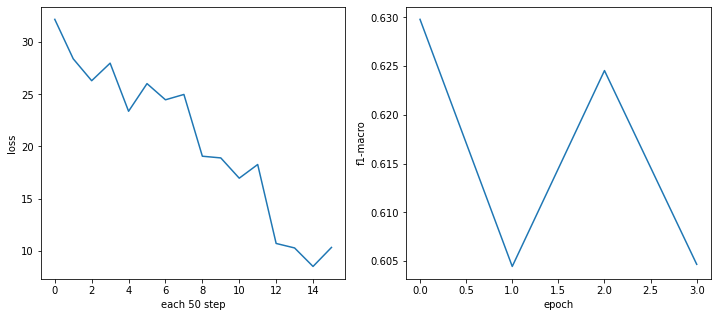

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(range(len(loss_collection)), loss_collection)
plt.xlabel(f'each {k} step')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(range(len(eval_f1_macro)), eval_f1_macro)
plt.xlabel(f'epoch')
plt.ylabel('f1-macro')

## Tesing

In [15]:
# test dataloader
test_dataset = NewsDataloader(test_data, tokenizer)
batch_size = 11
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

with torch.no_grad():
  all_pred = []
  all_label = []
  for j, data in enumerate(test_dataloader):
    input_ids = data[0]["input_ids"].squeeze().to(device)
    attention_mask = data[0]["attention_mask"].squeeze().to(device)
    labels = data[1].to(device)
    feed_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }
    output = best_model(feed_dict)
    pred = output.argmax(dim=1, keepdim=True)
    all_label.extend(list(labels.cpu().numpy()))
    all_pred.extend(list(pred.view(-1).cpu().numpy()))


  f1_macro = f1_score(all_label, all_pred, average='macro')
  f1_micro = f1_score(all_label, all_pred, average='micro')
  accuracy = accuracy_score(all_label, all_pred)
  recall = recall_score(all_label, all_pred)
  roc_auc = roc_auc_score(all_label, all_pred)

  print(f'ROC-AUC {roc_auc}')
  print(f'F1-macro {f1_macro}')
  print(f'F1-micro {f1_micro}')
  print(f'Accuracy {accuracy}')
  print(f'Recall {recall}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


ROC-AUC 0.6812223145071983
F1-macro 0.6487279986224971
F1-micro 0.7899603698811096
Accuracy 0.7899603698811096
Recall 0.5267857142857143


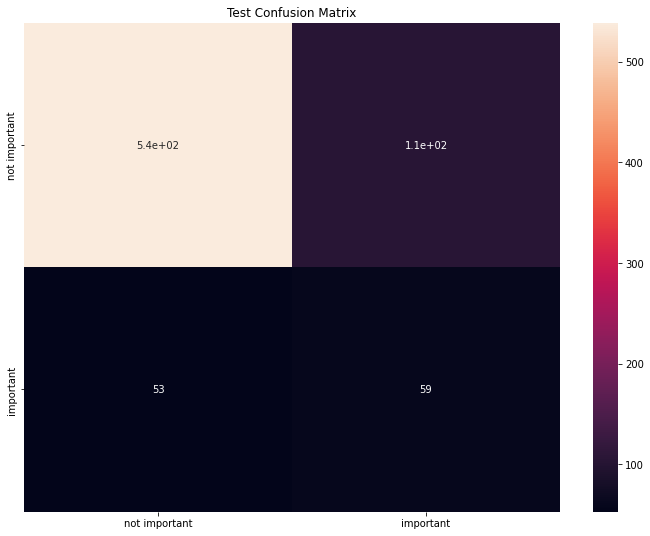

In [16]:
# confusion matrix for test data
classes = ['not important', 'important']
c_mat = confusion_matrix(all_label, all_pred)
df_cm = pd.DataFrame(c_mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (12,9))
plt.title('Test Confusion Matrix')
sn.heatmap(df_cm, annot=True)
plt.savefig('roberta_conf.jpg', dpi=400)